# Tables creation

### Import libraries

In [1]:
import sqlite3
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

### Data path and DB connection

In [2]:
DATA_PATH = '../data/'

In [3]:
conn = sqlite3.connect(DATA_PATH + 'technicalDebtDataset.db')

### Fetch main tables

In [4]:
query = ''' SELECT
                gc.projectID, gc.commitHash, gc.commitMessage,
                sm.complexity, sm.lines, sm.commentLines, sm.duplicatedLines,
                sm.violations, sm.blockerViolations, sm.criticalViolations, sm.majorViolations, sm.minorViolations,
                sm.bugs, sm.codeSmells 
            FROM
                GIT_COMMITS as gc
            INNER JOIN
                SONAR_MEASURES as sm
            WHERE
                gc.commitHash = sm.commitHash
'''

In [5]:
df = pd.read_sql_query(query, conn)
df.head()

,projectID,commitHash,commitMessage,complexity,lines,commentLines,duplicatedLines,violations,blockerViolations,criticalViolations,majorViolations,minorViolations,bugs,codeSmells
0,accumulo,e0880e263e4bf8662ba3848405200473a25dfc9f,ACCUMULO-1 initial checkin of source code\n\ng...,43137,263680,13509,46445,18314,142,893,7310,9889,464,17012
1,accumulo,e8774c5ec3a35e042f320540b5f7e66ebd2d9e87,"ACCUMULO-2 moved cloudtrace for TRUNK, fixed p...",43137,262753,13507,46301,18169,142,893,7164,9890,344,16987
2,accumulo,2032ebbd0ed90734da39ca238bbd10dee24d0030,ACCUMULO-2 fixed thrift build script to point ...,43137,262753,13507,46301,18169,142,893,7164,9890,344,16987
3,accumulo,de297d4932e08625a5df146f0802041bb5aeb892,ACCUMULO-2 reverted change to config.html\n\ng...,43137,263643,13507,46445,18315,142,893,7310,9890,464,17013
4,accumulo,34efaae87639a83b60fdb7274de4b45051025a3a,ACCUMULO-2 fixed cloudtrace references in cont...,43137,263639,13507,46445,18315,142,893,7310,9890,464,17013


### Convert some columns to numeric

In [6]:
cols = [i for i in df.columns if i not in ['projectID','commitHash','commitMessage']]
for col in cols:
    df[col] = df[col].astype(int)

In [7]:
df.dtypes

projectID             object
commitHash            object
commitMessage         object
complexity             int64
lines                  int64
commentLines           int64
duplicatedLines        int64
violations             int64
blockerViolations      int64
criticalViolations     int64
majorViolations        int64
minorViolations        int64
bugs                   int64
codeSmells             int64
dtype: object

### Columns metrics

In [8]:
df.describe()

,complexity,lines,commentLines,duplicatedLines,violations,blockerViolations,criticalViolations,majorViolations,minorViolations,bugs,codeSmells
count,55629.000000,5.562900e+04,55629.000000,55629.000000,55629.000000,55629.000000,55629.000000,55629.000000,55629.000000,55629.000000,55629.000000
mean,12112.140179,1.327941e+05,17577.502921,15517.791602,5440.302198,27.425030,373.338097,2375.444157,2563.342861,74.626670,5235.007442
std,15175.782233,1.515171e+05,18922.274369,24901.111445,6642.833830,53.010832,355.199801,2700.680993,3778.729807,113.049746,6368.548284
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2522.000000,2.941900e+04,4205.000000,2048.000000,1197.000000,2.000000,85.000000,498.000000,397.000000,6.000000,1168.000000
50%,5302.000000,6.624600e+04,10221.000000,6113.000000,2291.000000,8.000000,240.000000,1050.000000,899.000000,19.000000,2163.000000
75%,14080.000000,1.663610e+05,22674.000000,19504.000000,9358.000000,38.000000,626.000000,3188.000000,4050.000000,112.000000,9018.000000
max,139214.000000,1.175349e+06,125220.000000,264993.000000,48093.000000,419.000000,1305.000000,24772.000000,21509.000000,1505.000000,45538.000000


### Preprocessing on "violations" types

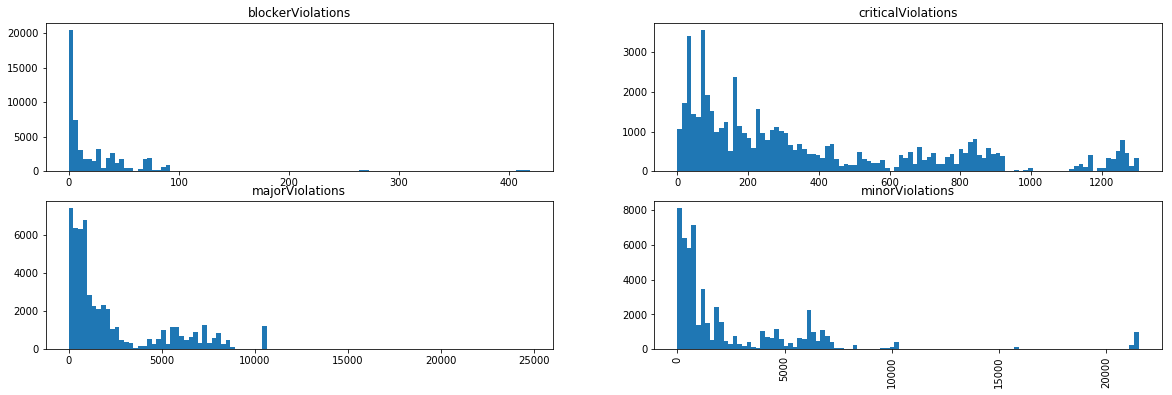

In [9]:
fig , ax = plt.subplots(2,2, figsize=(20,6))
ax[0,0].hist(df['blockerViolations'], bins=100)
ax[0,1].hist(df['criticalViolations'], bins=100)
ax[1,0].hist(df['majorViolations'], bins=100)
ax[1,1].hist(df['minorViolations'], bins=100)

ax[0,0].title.set_text('blockerViolations')
ax[0,1].title.set_text('criticalViolations')
ax[1,0].title.set_text('majorViolations')
ax[1,1].title.set_text('minorViolations')
plt.xticks(rotation='vertical')
plt.show()

Cut violations only where there is data.

In [10]:
df['blockerViolations'] = df['blockerViolations'].where(df['blockerViolations'] <= 100, 100)
df['majorViolations'] = df['majorViolations'].where(df['majorViolations'] <= 10000, 10000)
df['minorViolations'] = df['minorViolations'].where(df['minorViolations'] <= 10000, 10000)

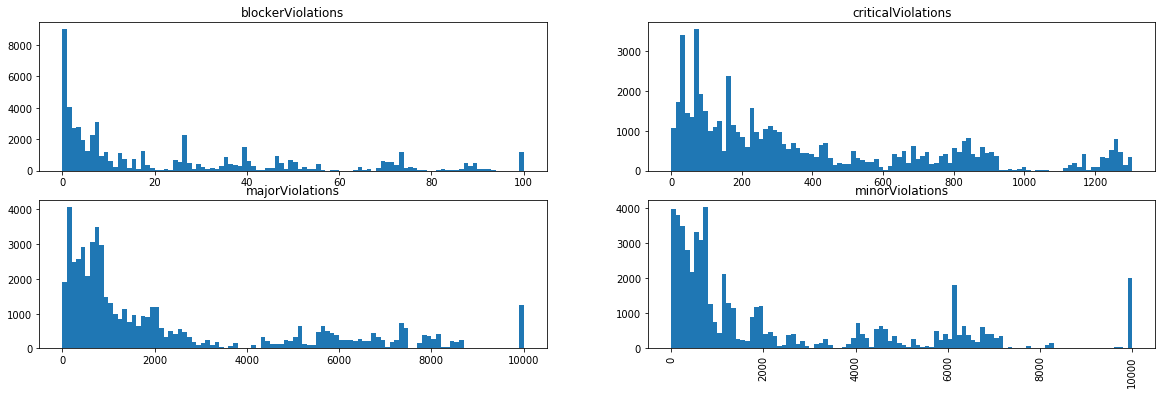

In [11]:
fig , ax = plt.subplots(2,2, figsize=(20,6))
ax[0,0].hist(df['blockerViolations'], bins=100)
ax[0,1].hist(df['criticalViolations'], bins=100)
ax[1,0].hist(df['majorViolations'], bins=100)
ax[1,1].hist(df['minorViolations'], bins=100)

ax[0,0].title.set_text('blockerViolations')
ax[0,1].title.set_text('criticalViolations')
ax[1,0].title.set_text('majorViolations')
ax[1,1].title.set_text('minorViolations')
plt.xticks(rotation='vertical')
plt.show()

We merge minor and major violations into one, by adding them up.

In [12]:
df = df.assign(mimaViolations = df['minorViolations'] + df['majorViolations'])

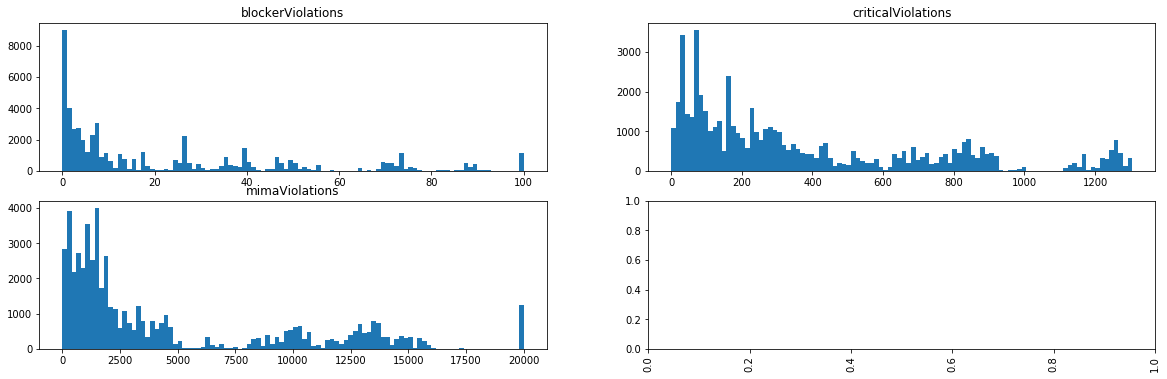

In [13]:
fig , ax = plt.subplots(2,2, figsize=(20,6))
ax[0,0].hist(df['blockerViolations'], bins=100)
ax[0,1].hist(df['criticalViolations'], bins=100)
ax[1,0].hist(df['mimaViolations'], bins=100)

ax[0,0].title.set_text('blockerViolations')
ax[0,1].title.set_text('criticalViolations')
ax[1,0].title.set_text('mimaViolations')
plt.xticks(rotation='vertical')
plt.show()

Create bins for 4 different groups.

In [14]:
def categorize_1(N_BINS, v):
    bins = np.arange(min(v), max(v)+1, step = max(v)//N_BINS)
    bins[-1] += 1
    bins[0] = -1
    return bins

def categorize_2(n_groups, v):
    v = v.sort_values()
    n = len(v)
    id_seps = [int(i*n/n_groups) for i in range(0,n_groups+1)]
    seps = [v.iloc[el-1] for el in id_seps]
    seps[0] = v.iloc[0]-1
    return seps

In [15]:
v = df.blockerViolations
n_groups = 3

categorize_2(n_groups, v)

[-1, 4, 26, 100]

In [16]:
v = df.blockerViolations
N_BINS = 3

categorize_1(N_BINS, v)

array([ -1,  33,  66, 100])

In [17]:
'''
N_BINS = 3
bins_blocker = np.arange(min(df.blockerViolations), max(df.blockerViolations)+1, step = max(df.blockerViolations)//N_BINS)
bins_blocker[-1] += 1
bins_blocker[0] = -1
bins_blocker

bins_critical = np.arange(min(df.criticalViolations), max(df.criticalViolations)+1, step = max(df.criticalViolations)//N_BINS)
bins_critical[-1] += 1
bins_critical[0] = -1
bins_critical

bins_mami = np.arange(min(df.mamiViolations), max(df.mamiViolations)+1, step = max(df.mamiViolations)//N_BINS)
bins_mami[-1] += 1
bins_mami[0] = -1
bins_mami
'''

'\nN_BINS = 3\nbins_blocker = np.arange(min(df.blockerViolations), max(df.blockerViolations)+1, step = max(df.blockerViolations)//N_BINS)\nbins_blocker[-1] += 1\nbins_blocker[0] = -1\nbins_blocker\n\nbins_critical = np.arange(min(df.criticalViolations), max(df.criticalViolations)+1, step = max(df.criticalViolations)//N_BINS)\nbins_critical[-1] += 1\nbins_critical[0] = -1\nbins_critical\n\nbins_mami = np.arange(min(df.mamiViolations), max(df.mamiViolations)+1, step = max(df.mamiViolations)//N_BINS)\nbins_mami[-1] += 1\nbins_mami[0] = -1\nbins_mami\n'

Create interval variables for each violation.

In [18]:
n_groups = 3

In [19]:
df['bin_blockerViolations'] = pd.cut(df['blockerViolations'], categorize_2(n_groups, df['blockerViolations']))
df['bin_criticalViolations'] = pd.cut(df['criticalViolations'], categorize_2(n_groups, df['criticalViolations']))
df['bin_mimaViolations'] = pd.cut(df['mimaViolations'], categorize_2(n_groups, df['mimaViolations']))

In [20]:
df['class_blockerViolations'] = df['bin_blockerViolations'].cat.codes.astype(str)
df['class_criticalViolations'] = df['bin_criticalViolations'].cat.codes.astype(str)
df['class_mimaViolations'] = df['bin_mimaViolations'].cat.codes.astype(str)

Merge them all and create a colum paste of all combination of classes.

In [21]:
df["class"] = df["class_blockerViolations"] + df["class_criticalViolations"] + df["class_mimaViolations"]
df['class']

0        222
1        222
2        222
3        222
4        222
5        222
6        222
7        222
8        222
9        222
10       222
11       222
12       222
13       222
14       222
15       222
16       222
17       222
18       222
19       222
20       222
21       222
22       222
23       222
24       222
25       222
26       222
27       222
28       222
29       222
        ... 
55599    122
55600    122
55601    122
55602    122
55603    122
55604    122
55605    122
55606    122
55607    122
55608    122
55609    122
55610    122
55611    122
55612    122
55613    122
55614    122
55615    122
55616    122
55617    122
55618    122
55619    122
55620    122
55621    122
55622    122
55623    122
55624    122
55625    122
55626    122
55627    122
55628    122
Name: class, Length: 55629, dtype: object

Assign a category to each combination of class.

In [22]:
df['class'] = df['class'].astype('category')
df['category'] = df['class'].cat.codes
df[['class','category']]

,class,category
0,222,22
1,222,22
2,222,22
3,222,22
4,222,22
5,222,22
6,222,22
7,222,22
8,222,22
9,222,22


We get the combination categories below.

In [23]:
print(sorted(df.category.unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]


Check if there are NA categories.

In [24]:
df[df.category.isna()]

,projectID,commitHash,commitMessage,complexity,lines,commentLines,duplicatedLines,violations,blockerViolations,criticalViolations,...,codeSmells,mimaViolations,bin_blockerViolations,bin_criticalViolations,bin_mimaViolations,class_blockerViolations,class_criticalViolations,class_mimaViolations,class,category


We create a lookup table of the data created (in order to check which intervals where chosen, if needed)

In [25]:
viols = ['bin_blockerViolations','bin_criticalViolations','bin_mimaViolations']
categories = pd.DataFrame()
for v in viols:
    t = pd.DataFrame({'interval': df[v].unique()})
    t['type'] = v
    t['class'] = np.arange(0,len(df[v].unique()))
    categories = pd.concat([categories,t])
categories.reset_index(drop=True)

,interval,type,class
0,"(26, 100]",bin_blockerViolations,0
1,"(-1, 4]",bin_blockerViolations,1
2,"(4, 26]",bin_blockerViolations,2
3,"(404, 1305]",bin_criticalViolations,0
4,"(-1, 134]",bin_criticalViolations,1
5,"(134, 404]",bin_criticalViolations,2
6,"(4076, 20000]",bin_mimaViolations,0
7,"(-1, 1267]",bin_mimaViolations,1
8,"(1267, 4076]",bin_mimaViolations,2


### Resulting table

In [26]:
df

,projectID,commitHash,commitMessage,complexity,lines,commentLines,duplicatedLines,violations,blockerViolations,criticalViolations,...,codeSmells,mimaViolations,bin_blockerViolations,bin_criticalViolations,bin_mimaViolations,class_blockerViolations,class_criticalViolations,class_mimaViolations,class,category
0,accumulo,e0880e263e4bf8662ba3848405200473a25dfc9f,ACCUMULO-1 initial checkin of source code\n\ng...,43137,263680,13509,46445,18314,100,893,...,17012,17199,"(26, 100]","(404, 1305]","(4076, 20000]",2,2,2,222,22
1,accumulo,e8774c5ec3a35e042f320540b5f7e66ebd2d9e87,"ACCUMULO-2 moved cloudtrace for TRUNK, fixed p...",43137,262753,13507,46301,18169,100,893,...,16987,17054,"(26, 100]","(404, 1305]","(4076, 20000]",2,2,2,222,22
2,accumulo,2032ebbd0ed90734da39ca238bbd10dee24d0030,ACCUMULO-2 fixed thrift build script to point ...,43137,262753,13507,46301,18169,100,893,...,16987,17054,"(26, 100]","(404, 1305]","(4076, 20000]",2,2,2,222,22
3,accumulo,de297d4932e08625a5df146f0802041bb5aeb892,ACCUMULO-2 reverted change to config.html\n\ng...,43137,263643,13507,46445,18315,100,893,...,17013,17200,"(26, 100]","(404, 1305]","(4076, 20000]",2,2,2,222,22
4,accumulo,34efaae87639a83b60fdb7274de4b45051025a3a,ACCUMULO-2 fixed cloudtrace references in cont...,43137,263639,13507,46445,18315,100,893,...,17013,17200,"(26, 100]","(404, 1305]","(4076, 20000]",2,2,2,222,22
5,accumulo,7e9bba037c4fbd70c7efe1aefc7f2724ec78fcc7,ACCUMULO-5 made log recovery convert tablet fi...,43139,263646,13507,46445,18315,100,893,...,17013,17200,"(26, 100]","(404, 1305]","(4076, 20000]",2,2,2,222,22
6,accumulo,d410b89d9a0dfd7cbeb9766bbf32ab033cc802ea,ACCUMULO-17 moved Filter instantiation before ...,43139,263646,13507,46445,18315,100,893,...,17013,17200,"(26, 100]","(404, 1305]","(4076, 20000]",2,2,2,222,22
7,accumulo,228dd5b26313a9ce158712df1acabbd193c5ef98,ACCUMULO-5 added unit test for log recovery th...,43142,263702,13509,46445,18320,100,893,...,17018,17205,"(26, 100]","(404, 1305]","(4076, 20000]",2,2,2,222,22
8,accumulo,82fc84f1331ade3f17a721fa0b86cd63b73746a2,ACCUMULO-15 threw RuntimeExceptions in Wrappin...,43150,263700,13506,46445,18341,100,893,...,17039,17226,"(26, 100]","(404, 1305]","(4076, 20000]",2,2,2,222,22
9,accumulo,5d9e3642f16050347b2a5b3a5f33724795a6300e,ACCUMULO-16 Use correct path when deleting tse...,43150,263700,13506,46445,18341,100,893,...,17039,17226,"(26, 100]","(404, 1305]","(4076, 20000]",2,2,2,222,22


In [27]:
df['category'].value_counts(), df['category'].count(), 

(22    12723
 0     10088
 4      5735
 11     4257
 7      3834
 12     3221
 3      2479
 8      2337
 13     2150
 14     1217
 21      995
 16      925
 18      839
 6       838
 19      818
 10      594
 15      531
 5       485
 1       448
 17      421
 2       386
 9       176
 20      132
 Name: category, dtype: int64, 55629)

In [28]:
import seaborn as sns
fig , ax = plt.subplots(1,1, figsize=(15,5))
sns.histplot(df['category'], bins=100, ax =ax)
ax.set_xticks(df.category.unique())
ax.set_xlabel("Category")
ax.set_ylabel("Count [log scale]")
ax.set_title('Histogram of values per category')
#ax.set_yscale('log')
plt.show()

ImportError: No module named seaborn

### Save table data

Save it as pickle.

In [ ]:
SAVE_PATH = '../data/our_data/'

In [ ]:
filename = 'commits_violations.pkl'

df.to_pickle(SAVE_PATH + filename)

We can read it by using:

In [ ]:
df = pd.read_pickle(SAVE_PATH + filename)
df.head()

In [ ]:
dff = df[['complexity', 'lines', 'commentLines', 'duplicatedLines', 'violations','category']]

In [ ]:
colormap = plt.cm.viridis
plt.figure(figsize=(10,10))
plt.title('Pearson Correlation of Features', size=15)

sns.heatmap(dff.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [ ]:
dff.isna().sum()

In [ ]:
import sys

!{sys.executable} -m pip install 'sklearn'
!{sys.executable} -m pip install 'xgboost'

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
y = dff['category']
X = dff.drop(['violations', 'category'], axis=1)
RS = 123

# Split dataframe into training and test/validation set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RS)

In [ ]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
import xgboost

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    XGBClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis()]#,
    #QuadraticDiscriminantAnalysis()]

In [ ]:
# Logging for Visual Comparison
#log_cols=["Classifier", "Accuracy", "Log Loss"]
log_cols=["Classifier", "Accuracy"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    
    #train_predictions = clf.predict_proba(X_test)
    #ll = log_loss(y_test, train_predictions)
    #print("Log Loss: {}".format(ll))
    
    #log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log_entry = pd.DataFrame([[name, acc*100]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)


In [ ]:
log

In [ ]:
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
plt.show()

#sns.set_color_codes("muted")
#sns.barplot(x='Log Loss', y='Classifier', data=log, color="g")

#plt.xlabel('Log Loss')
#plt.title('Classifier Log Loss')
#plt.show()

In [ ]:
# Inspect the learned Decision Trees
# One of the major advantage of Decision Trees is the fact that they can easily be interpreted.  
clf = DecisionTreeClassifier()

# Fit with all the training set
clf.fit(X, y)
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

print("Feature ranking:")
for f in range(X.shape[1]):
    print("%s : (%f)" % (feature_names[f] , importances[indices[f]]))

In [ ]:
f, ax = plt.subplots(figsize=(10, 6))
plt.title("Feature ranking", fontsize = 12)
plt.bar(range(X.shape[1]), importances[indices],
    color="b", 
    align="center")
plt.xticks(range(X.shape[1]), feature_names)
plt.xlim([-1, X.shape[1]])
plt.ylabel("Importance", fontsize = 18)
plt.xlabel("Index of the feature", fontsize = 18)